In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
#import xgboost as xgb
#import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
import json
import ast
import eli5
from functools import reduce
import warnings
from sklearn.metrics import mean_squared_error
from scipy import stats
from math import sqrt
from lightgbm import plot_tree
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample
import time
import gc
warnings.filterwarnings('ignore')
#import shap

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
train = pd.read_csv('dataset-0510/train.csv')
test  = pd.read_csv('dataset-0510/test.csv')
data = pd.concat([train, test], axis=0)
gc.collect()
#train.drop(['village'], axis =1, inplace = True)
#test.drop(['village'], axis =1, inplace = True)

481

In [21]:
#categorical feature to one-hot
def one_hot(train, test, categorical_features):
    data = pd.concat([train, test], axis=0)
    for i in categorical_features:
        data = data.join(pd.get_dummies(data[i], prefix = i))
        data.drop(i, axis = 1, inplace =True)
    train = data[:60000]
    test  = data[60000:]
    return train, test

In [4]:
def display_importances(feature_importance_df):
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

In [5]:
def Submission(Ids, preds):
    file_name = datetime.datetime.today().strftime('%m-%d-%H-%M')
    submission = pd.DataFrame({'building_id' : Ids, 'total_price' : preds})
    if not os.path.isdir('Submission'):
        os.makedirs('Submission')
    submission.to_csv('Submission/' + file_name + '.csv', index= False)

In [6]:
def lgb_model(split_num, train, test,features, stratified = False, if_one_hot = True):
    '''
    category_cols = ['building_material',
 'building_type',
 'building_use',
 'parking_way',
 'location_2',
 'inter_btw_building_type_parking_way',
 'inter_btw_building_type_building_use',
 'inter_btw_building_type_building_material',
 'inter_btw_parking_way_building_use',
 'inter_btw_parking_way_building_material',
 'inter_btw_building_use_building_material']
    '''
    category_cols = ['building_material','building_type','building_use','parking_way']
    
    if stratified:
        kf = StratifiedKFold(n_splits = split_num, random_state = 42, shuffle = True)
    else :
        kf = KFold(n_splits = split_num, random_state=42, shuffle=True)
    train['total_price_log'] = np.log1p(train['total_price'])
    feature_importance_df = pd.DataFrame()
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    
    param ={
        'n_estimators': 10000, 'max_depth' : -1, 'num_leaves' :30,         
        'objective': 'regression',   'metric':'rmse',   
        'learning_rate': 0.01,      'boosting': 'gbdt',     'min_data_in_leaf': 10,
        'feature_fraction': 0.9,    'bagging_freq':1,       'bagging_fraction': 0.8,     'importance_type': 'gain',
        'lambda_l1': 0.2,  'subsample': .8,   'colsample_bytree': .9
    }

    print(len(features))        
    for fold_, (trn_idx, val_idx) in enumerate(kf.split(train[features].values,train['total_price_log'].values)):
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label= train['total_price_log'].iloc[trn_idx])
        val_data = lgb.Dataset(train.iloc[val_idx][features], label= train['total_price_log'].iloc[val_idx])
        
        clf = lgb.train(params= param, train_set= trn_data, valid_sets= [trn_data, val_data], verbose_eval=1000, early_stopping_rounds= 3000, categorical_feature=category_cols)
        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration = clf.best_iteration)
        predictions += clf.predict(test[features], num_iteration = clf.best_iteration) / kf.n_splits
        
        y   = np.expm1(train['total_price_log'].iloc[val_idx]) 
        yhat = np.expm1(oof[val_idx])
        Hit_score = np.sum([1 for i in np.abs((y - yhat) / y)  if i <= 0.1 ])
        print('fold {} hit_score : {}'.format(fold_ + 1, round(Hit_score, 4) /len(train.iloc[val_idx]) * 10000))
        print('-'*30)
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature']    = features
        fold_importance_df['importance'] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
        fold_importance_df['fold']       = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('CV scrore : {}'.format(sqrt(mean_squared_error(train['total_price_log'], oof))))
    print('-'*30)
    y = np.expm1(train['total_price_log']) 
    yhat = np.expm1(oof)
    Hit_score = np.sum([1 for i in np.abs((y - yhat) / y)  if i <= 0.1 ])
    print('Hit rate : {}'.format(round(Hit_score, 4) /len(train) * 10000))
    
    display_importances(feature_importance_df)
    return predictions, round(Hit_score, 4) /len(train) * 10000, oof


In [9]:
def feature_process(df):
    df['min_cat'] = 0
    for col in [i for i in df.columns if 'MIN' in i]:
        df['min_cat'] = df.apply(lambda x : col if x['min_cat'] == x[col] else x['min_cat'], axis=1)
        
    #Impute missing value
    #df['village_income_median'] = df.groupby(['city', 'town'])['village_income_median'].transform(lambda x : x .fillna(x.median()))
    df['village_income_mean'] = df.groupby(['town'])['village_income_median'].transform(lambda x : x .fillna(x.mean()))
    
    #floor
    df.loc[df['txn_floor'].isna(), 'department'] = 1 
    df.loc[df['txn_floor'].notna(), 'department'] = 0
    df.loc[df['txn_floor'].isna(), 'txn_floor'] = df.loc[df['txn_floor'].isna(), 'total_floor'] 
    df['avg_height_floor'] = df['txn_floor'] / df['total_floor'] 
    df['avg_height_floor'].fillna(1, inplace = True)
    
    #location
    df['location_2'] = df.apply(lambda x : int(str(x['town']) + str(x['village'])), axis=1)
    df['location_2'] = df['location_2'].astype('category')
    df['town'] = df['town'].astype('category')
    
    #date
    df['day_between_txn_complete'] = df['txn_dt'] - df['building_complete_dt']
    df['year_between_txn_complete'] = round(df['day_between_txn_complete'] / 365)
    
    #area
    #df['land*bulid_area'] = df['land_area'] * df ['building_area']
    df['land/bulid_area'] = df['land_area'] / df ['building_area']
    df['house_area'] = df['building_area'] - df['parking_area']
    df['house_rate']  = df['building_area'] / df['house_area']
    
    #parking
    df['miss_parking_area'] = 0
    df['miss_parking_price'] = 0
    df.loc[df['parking_area'].isna(), 'miss_parking_area'] = 1
    df.loc[df['parking_price'].isna(), 'miss_parking_price'] = 1
    df['parking_price_every_area'] = df['parking_price'] / df['parking_area']
    df['parking_way'] = df['parking_way'].astype('category')
    df['parking_area'].fillna(0, inplace =True)
    df['parking_price'].fillna(0, inplace =True)
    
    #population
    
    #soical rate
    df['natural_diff'] = df['born_rate'] - df['death_rate']
    df['natural_rate'] = df['born_rate'] / df['death_rate']
    
    df['marry_diff'] = df['marriage_rate'] - df['divorce_rate']
    df['marry_rate'] = df['marriage_rate'] / df['divorce_rate']
    
    df['total_diff_sum'] = df['natural_rate'] + df['marry_diff']
    df['total_diff_diff'] = df['natural_rate'] - df['marry_diff']
    df['total_rate_diff'] = df['born_rate'] + df['marry_rate']
    
    df['positive_grow_rate'] = df['born_rate'] + df['marriage_rate']
    df['negative_grow_rate'] = df['death_rate'] + df['divorce_rate']
    df['tatal_rate_sum'] = df['born_rate'] + df['death_rate'] + df['born_rate'] + df['death_rate']
    
    #building   #building_type = 4 is house
    df['building_type'] = df['building_type'].astype('category')
    df['building_use'] = df['building_use'].astype('category')
    df['building_material'] = df['building_material'].astype('category')
    df = df.join(pd.get_dummies(df['building_type'], prefix = 'building_type'))
    
    '''
    #degree rate
    #df['all_degree'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate'] + df['jobschool_rate'] + df['junior_rate'] + df['elementary_rate']
    #df['junior_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate'] + df['jobschool_rate'] + df['junior_rate'] 
    #df['jobschool_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate'] +  df['jobschool_rate']
    #df['highschool_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate']
    #df['bachelor_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate']
    #df['master_above_rate'] = df['doc_rate'] + df['master_rate'] 
    '''
    
    #MIN
    MIN_cols = [i for i in df.columns if '_MIN' in i]
    df['MIN_dis_plus'] = reduce(lambda x,y: x + y, [df[i] for i in [i for i in df.columns if '_MIN' in i]])
    
    #10 50 100 250 500 1000 5000 10000
    df['diff_500_50'] = df['N_500'] - df['N_50']
    df['diff_1000_500'] = df['N_1000'] - df['N_500']
    df['diff_5000_1000'] = df['N_5000'] - df['N_1000']
    df['diff_10000_5000'] = df['N_10000'] - df['N_5000']
    '''
    All_10    = [i for i in df.columns if i.endswith('_10') and 'index' not in i and 'N' not in i]
    All_50    = [i for i in df.columns if i.endswith('_50') and 'index' not in i and 'N' not in i]
    All_100   = [i for i in df.columns if i.endswith('_100') and 'index' not in i and 'N' not in i]
    All_250   = [i for i in df.columns if i.endswith('_250') and 'index' not in i and 'N' not in i]
    All_500   = [i for i in df.columns if i.endswith('_500') and 'index' not in i and 'N' not in i]
    All_1000  = [i for i in df.columns if i.endswith('_1000') and 'index' not in i and 'N' not in i]
    All_5000  = [i for i in df.columns if i.endswith('_5000') and 'index' not in i and 'N' not in i]
    All_10000 = [i for i in df.columns if i.endswith('_10000') and 'index' not in i and 'N' not in i]
    df['All_10'] = reduce(lambda x, y: x + y, [df[i] for i in All_10])
    df['All_50'] = reduce(lambda x, y: x + y, [df[i] for i in All_50])
    df['All_100'] = reduce(lambda x, y: x + y, [df[i] for i in All_100])
    df['All_250'] = reduce(lambda x, y: x + y, [df[i] for i in All_250])
    df['All_500'] = reduce(lambda x, y: x + y, [df[i] for i in All_500])
    df['All_1000'] = reduce(lambda x, y: x + y, [df[i] for i in All_1000])
    df['All_5000'] = reduce(lambda x, y: x + y, [df[i] for i in All_5000])
    df['All_10000'] = reduce(lambda x, y: x + y, [df[i] for i in All_10000])
    
    for i,j in  zip([All_10, All_50, All_100, All_250, All_500, All_1000, All_5000], [All_50, All_100, All_250, All_500, All_1000, All_5000, All_10000]):
        for order in range(len(i)):
            df[j[order] + '_' + i[order] + 'rate'] = df[j[order]] / df[i[order]]
    '''
    #interection
    inter_cols = ['building_type', 'parking_way', 'building_use', 'building_material']
    for i in range(4):
        for j in range(4):
            if j > i:
                df['inter_btw_' + inter_cols[i] + '_' + inter_cols[j]] = df.apply(lambda x : str(x[inter_cols[i]]) + str(x[inter_cols[j]]), axis=1)
                df['inter_btw_' + inter_cols[i] + '_' + inter_cols[j]] = df['inter_btw_' + inter_cols[i] + '_' + inter_cols[j]].astype('category')
    

    
    #groupby encoding
    category_cols  = ['building_material','building_type','building_use','parking_way','location_2']
    numerical_cols = ['building_area', 'land_area', 'day_between_txn_complete', 'txn_dt', 'building_complete_dt', 'house_area', 'house_rate']
    statistics = ['mean', 'median', 'max', 'min']
    for category in category_cols:
        for numerical in numerical_cols:
            for stat in statistics:
                df[numerical + '_' + stat + '_gb_' + category] = df.groupby([category])[numerical].transform(stat)
                df[numerical + '_diff_' + stat + '_gb_' + category] = df[numerical] - df[numerical + '_' + stat + '_gb_' + category]

    category_cols =['town', 'location_2']
    count_cols = ['building_type', 'building_use', 'building_material', 'parking_way']
    for category in category_cols:
        for count_col in count_cols:
            df['size_gb_' + category + '_' + count_col] = df.groupby([category, count_col])[count_col].transform('size')
    #Polynomail feature
    
    #useless cols
    #df.drop(['village'], axis = 1, inplace = True)
    df.drop([i for i in train.columns if np.sum(train[i]) == 60000 and 'index' in i], axis = 1, inplace = True)
    return df

In [10]:
data = feature_process(data)
train = data[:60000]
test = data[60000:]
gc.collect()

63

338
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.14452	valid_1's rmse: 0.231433
[2000]	training's rmse: 0.0961681	valid_1's rmse: 0.221103
[3000]	training's rmse: 0.0704599	valid_1's rmse: 0.217666
[4000]	training's rmse: 0.0546591	valid_1's rmse: 0.216233
[5000]	training's rmse: 0.0441212	valid_1's rmse: 0.215518
[6000]	training's rmse: 0.036553	valid_1's rmse: 0.215159
[7000]	training's rmse: 0.0310198	valid_1's rmse: 0.214974
[8000]	training's rmse: 0.0267819	valid_1's rmse: 0.214839
[9000]	training's rmse: 0.023512	valid_1's rmse: 0.214723
[10000]	training's rmse: 0.0209299	valid_1's rmse: 0.214646
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.0209299	valid_1's rmse: 0.214646
fold 1 hit_score : 5034.526051475204
------------------------------
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.14377	valid_1's rmse: 0.235935
[2000]	training's rmse: 0.095693	valid_1's rmse:

[9000]	training's rmse: 0.0414874	valid_1's rmse: 0.158189
[10000]	training's rmse: 0.0378716	valid_1's rmse: 0.158005
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.0378716	valid_1's rmse: 0.158005
fold 4 hit_score : 6564.963132468853
------------------------------
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.134336	valid_1's rmse: 0.18716
[2000]	training's rmse: 0.104417	valid_1's rmse: 0.176473
[3000]	training's rmse: 0.0868769	valid_1's rmse: 0.172388
[4000]	training's rmse: 0.0743341	valid_1's rmse: 0.170155
[5000]	training's rmse: 0.0646331	valid_1's rmse: 0.168792
[6000]	training's rmse: 0.0569946	valid_1's rmse: 0.167911
[7000]	training's rmse: 0.0508223	valid_1's rmse: 0.167324
[8000]	training's rmse: 0.045692	valid_1's rmse: 0.166941
[9000]	training's rmse: 0.0413561	valid_1's rmse: 0.166632
[10000]	training's rmse: 0.0376818	valid_1's rmse: 0.166444
Did not meet early stopping. Best iteration is:
[10000

Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.0425755	valid_1's rmse: 0.339614
[2000]	training's rmse: 0.0233725	valid_1's rmse: 0.337441
[3000]	training's rmse: 0.0177377	valid_1's rmse: 0.337149
[4000]	training's rmse: 0.0145687	valid_1's rmse: 0.33715
[5000]	training's rmse: 0.014382	valid_1's rmse: 0.337122
[6000]	training's rmse: 0.014382	valid_1's rmse: 0.337122
[7000]	training's rmse: 0.014382	valid_1's rmse: 0.337122
Early stopping, best iteration is:
[4105]	training's rmse: 0.0143977	valid_1's rmse: 0.337122
fold 2 hit_score : 4365.482233502537
------------------------------
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.0576282	valid_1's rmse: 0.28324
[2000]	training's rmse: 0.0337509	valid_1's rmse: 0.282405
[3000]	training's rmse: 0.0241809	valid_1's rmse: 0.282107
[4000]	training's rmse: 0.0185934	valid_1's rmse: 0.28179
[5000]	training's rmse: 0.0151314	valid_1's rmse: 0.281654
[6000]	t

338
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.135409	valid_1's rmse: 0.205347
[2000]	training's rmse: 0.0963895	valid_1's rmse: 0.196814
[3000]	training's rmse: 0.0743444	valid_1's rmse: 0.1944
[4000]	training's rmse: 0.0597568	valid_1's rmse: 0.193764
[5000]	training's rmse: 0.0492598	valid_1's rmse: 0.193727
[6000]	training's rmse: 0.0416222	valid_1's rmse: 0.193939
[7000]	training's rmse: 0.0357166	valid_1's rmse: 0.194251
Early stopping, best iteration is:
[4485]	training's rmse: 0.0542487	valid_1's rmse: 0.193669
fold 1 hit_score : 5924.721189591078
------------------------------
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.138795	valid_1's rmse: 0.185042
[2000]	training's rmse: 0.0986123	valid_1's rmse: 0.174343
[3000]	training's rmse: 0.0762102	valid_1's rmse: 0.171046
[4000]	training's rmse: 0.0616471	valid_1's rmse: 0.169808
[5000]	training's rmse: 0.0513319	valid_1's rmse: 0.169151
[6

[9000]	training's rmse: 0.0140997	valid_1's rmse: 0.254467
[10000]	training's rmse: 0.0127277	valid_1's rmse: 0.254429
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.0127277	valid_1's rmse: 0.254429
fold 5 hit_score : 4765.957446808511
------------------------------
CV scrore : 0.23903175465468662
------------------------------
Hit rate : 4678.996598639456
City : 14
Train_num: 4704
Test_num: 768
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

338
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.0520096	valid_1's rmse: 0.387728
[2000]	training's rmse: 0.0236787	valid_1's rmse: 0.386278
[3000]	training's rmse: 0.0173065	valid_1's rmse: 0.386301
[4000]	training's rmse: 0.0159793	valid_1's rmse: 0.386292
Early stopping, best iteration is:
[1979]	training's rmse: 0.0239045	valid_1's rmse: 0.38627
fold 1 hit_score : 4285.714285714285
------------------------------
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.053725	valid_1's rmse: 0.354335
[2000]	training's rmse: 0.0227792	valid_1's rmse: 0.352238
[3000]	training's rmse: 0.0156542	valid_1's rmse: 0.352483
[4000]	training's rmse: 0.0146139	valid_1's rmse: 0.352477
Early stopping, best iteration is:
[1868]	training's rmse: 0.0247415	valid_1's rmse: 0.352205
fold 2 hit_score : 3959.1836734693875
------------------------------
Training until validation scores don't improve for 3000 rounds.
[1000]	tr

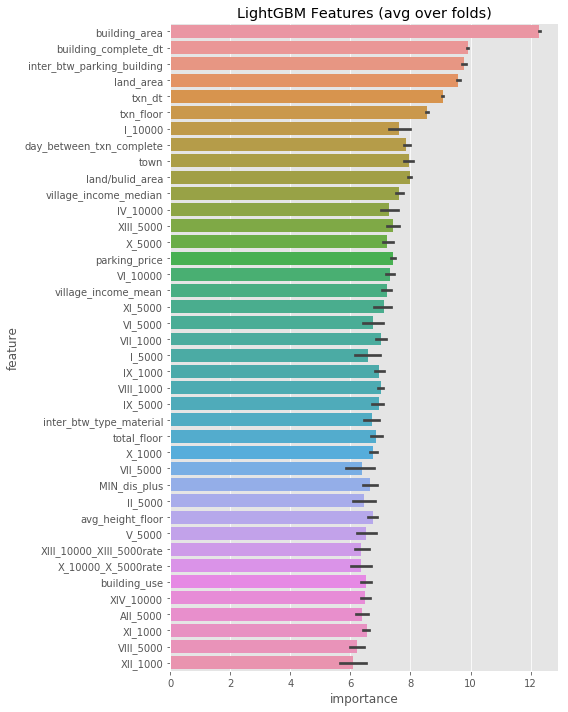

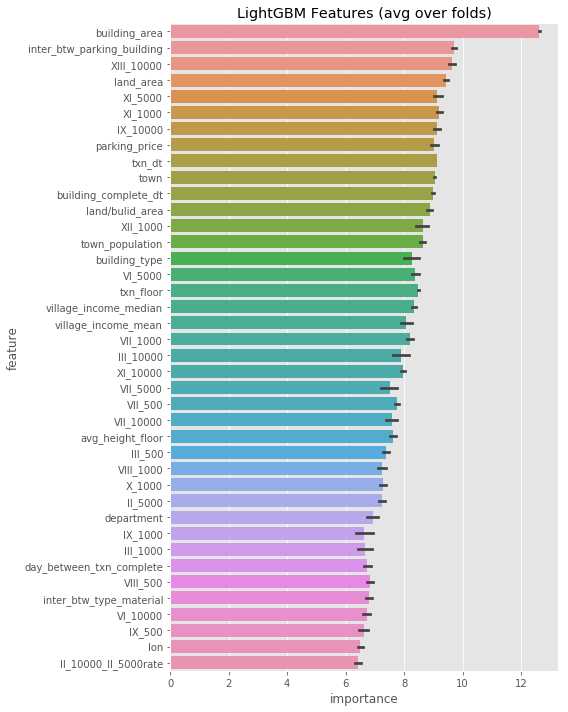

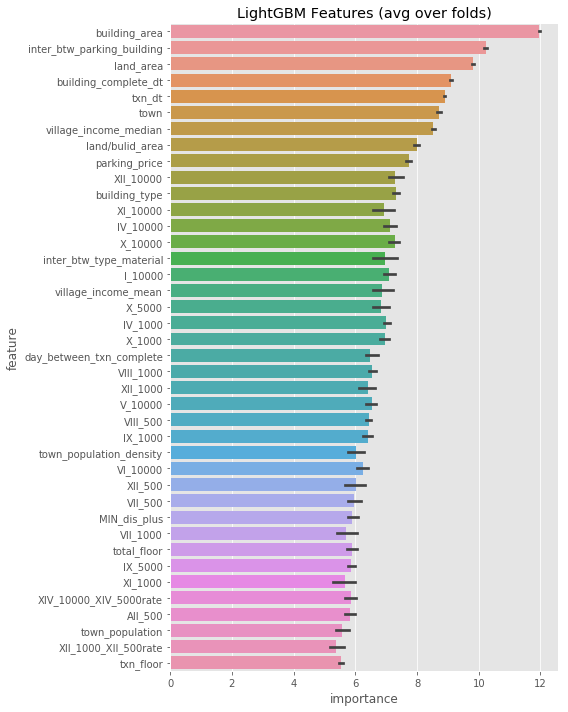

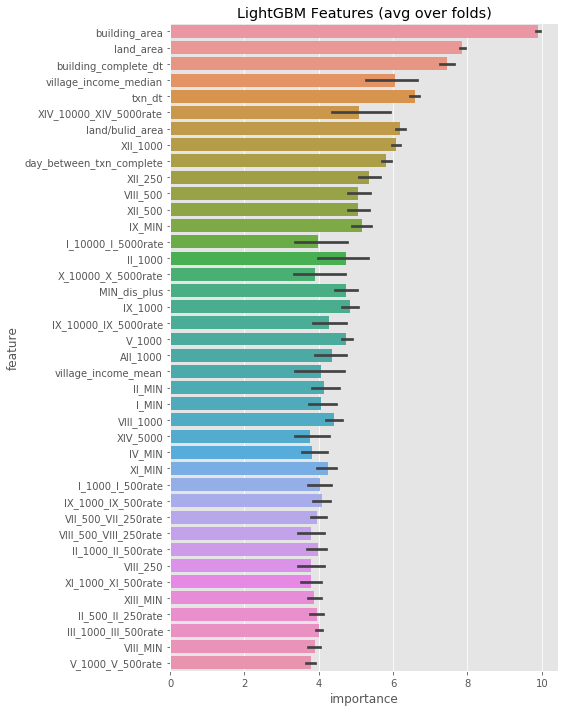

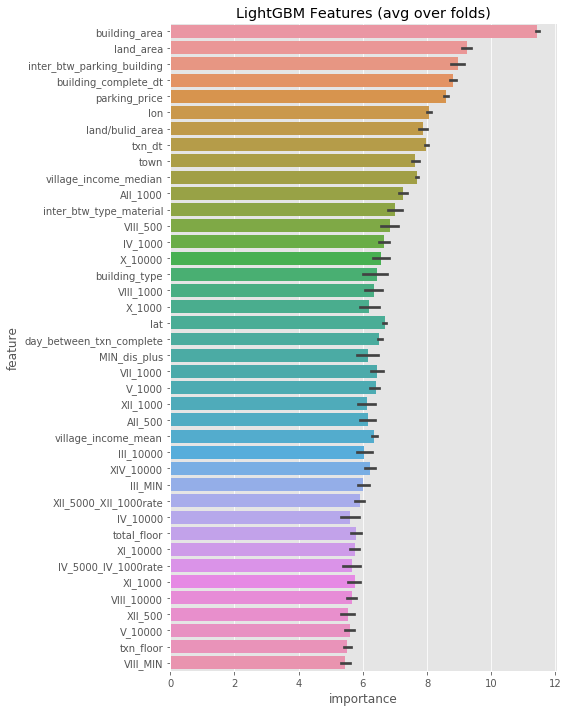

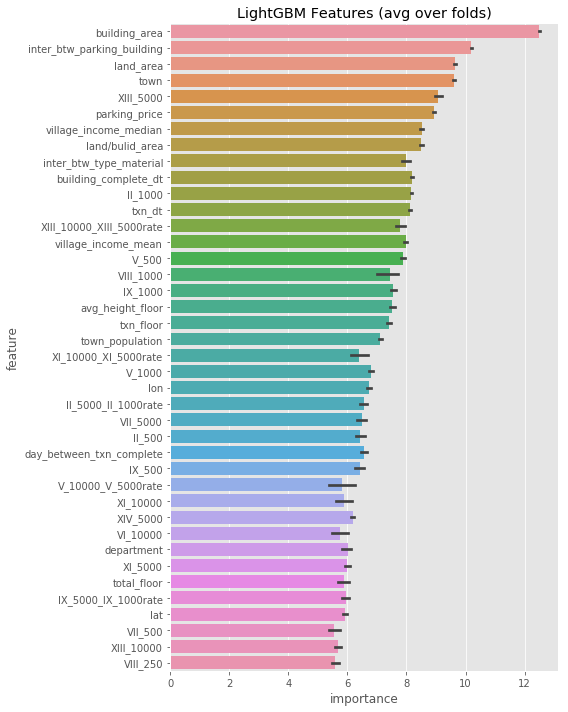

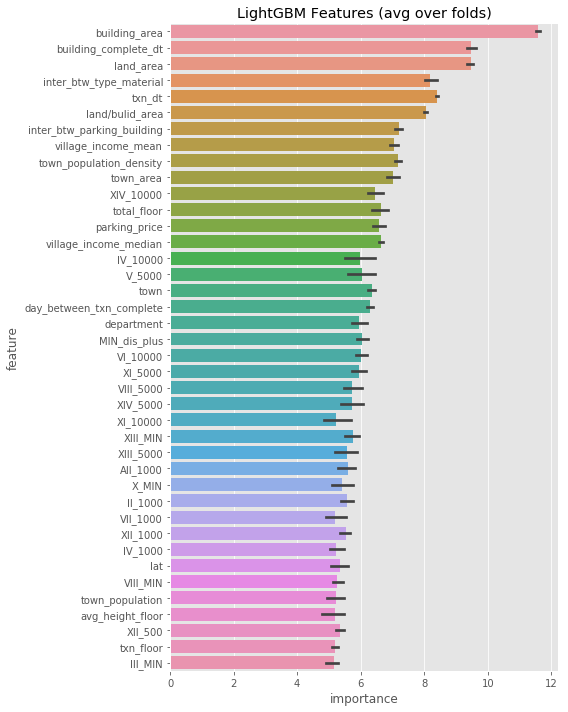

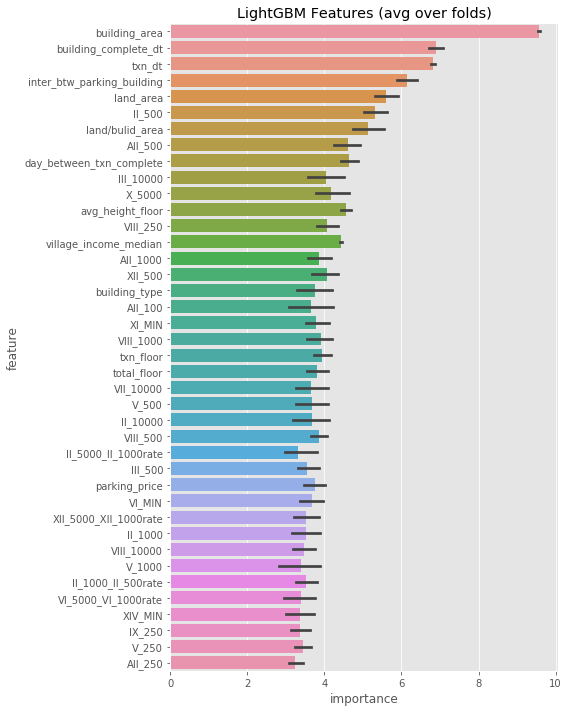

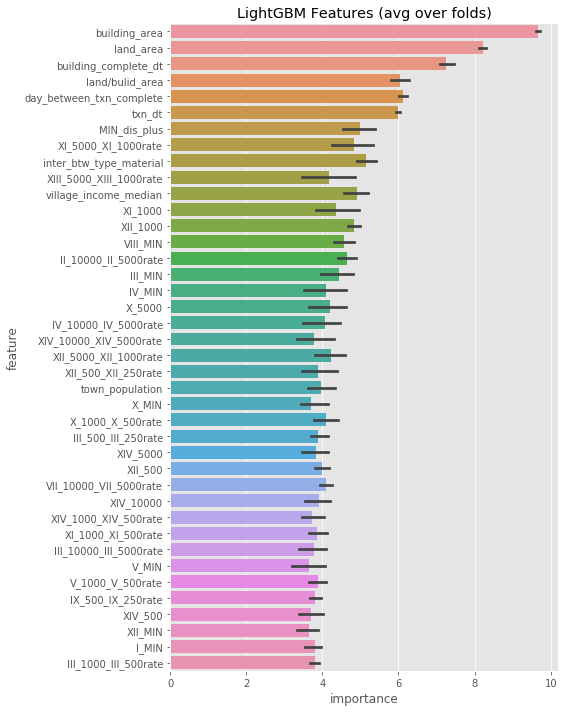

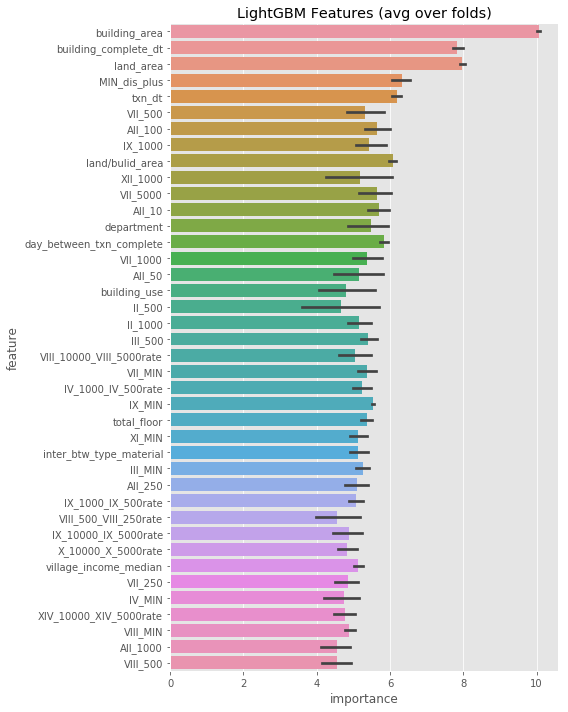

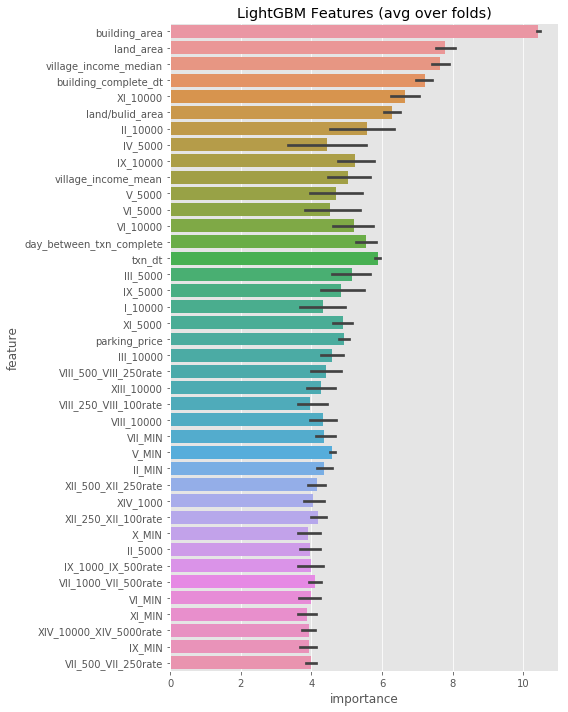

In [28]:
begin = time.time()
avg_hit_rate = 0
prediction_df = pd.DataFrame()
hit_score_list = []
train_num_list = []
city_df_list   = []
oof_list       = []
features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log','city']] 
for city in train['city'].unique():
    temp_train = train[train['city'] == city]
    temp_test  = test[test['city'] == city]
    temp_train.drop(['city'], axis =1, inplace =True)
    temp_test.drop(['city'], axis =1, inplace =True)
    preds, hit_score, oof = lgb_model(5, temp_train, temp_test, features= features,if_one_hot=False)
    temp = pd.DataFrame({'building_id' : temp_test['building_id'], 'total_price' : preds})
    prediction_df = pd.concat([prediction_df, temp], axis=0)
    
    print('City : {}'.format(city))
    print('Train_num: {}'.format(len(temp_train)))
    print('Test_num: {}'.format(len(temp_test)))
    print('-'*1000)
    hit_score_list.append(hit_score)
    train_num_list.append(len(temp_train))
    city_df_list.append(city)
    oof_list.append(oof)
    avg_hit_rate += hit_score / 60000 * len(temp_train)

Result_df = pd.DataFrame({'City' : city_df_list,
                        'Train_num' : train_num_list,
                        'Hit_score' : hit_score_list})

print('Avg hit_score : {}'.format(avg_hit_rate))
print('總共花：{} 分'.format((time.time() - begin) / 60))
print('現在時間 ： {}'.format(datetime.datetime.today().strftime('%m-%d-%H-%M')))
Submission(prediction_df['building_id'], np.expm1(prediction_df['total_price']))

In [11]:
begin = time.time()
avg_hit_rate = 0
prediction_df = pd.DataFrame()
hit_score_list = []
train_num_list = []
city_df_list   = []
oof_list       = []
features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log','city']] 
for city in train['city'].unique():
    temp_train = train[train['city'] == city]
    temp_test  = test[test['city'] == city]
    temp_train.drop(['city'], axis =1, inplace =True)
    temp_test.drop(['city'], axis =1, inplace =True)
    preds, hit_score, oof = lgb_model(5, temp_train, temp_test, features= features,if_one_hot=False)
    temp = pd.DataFrame({'building_id' : temp_test['building_id'], 'total_price' : preds})
    prediction_df = pd.concat([prediction_df, temp], axis=0)
    
    print('City : {}'.format(city))
    print('Train_num: {}'.format(len(temp_train)))
    print('Test_num: {}'.format(len(temp_test)))
    print('-'*1000)
    hit_score_list.append(hit_score)
    train_num_list.append(len(temp_train))
    city_df_list.append(city)
    oof_list.append(oof)
    avg_hit_rate += hit_score / 60000 * len(temp_train)

Result_df = pd.DataFrame({'City' : city_df_list,
                        'Train_num' : train_num_list,
                        'Hit_score' : hit_score_list})

print('Avg hit_score : {}'.format(avg_hit_rate))
print('總共花：{} 分'.format((time.time() - begin) / 60))
print('現在時間 ： {}'.format(datetime.datetime.today().strftime('%m-%d-%H-%M')))
Submission(prediction_df['building_id'], np.expm1(prediction_df['total_price']))

537
Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: nan	valid_1's rmse: nan
[2000]	training's rmse: nan	valid_1's rmse: nan
[3000]	training's rmse: nan	valid_1's rmse: nan


TypeError: 'NoneType' object is not iterable

In [69]:
train['preds'] = 0
for pred, city in zip(oof_list, train['city'].unique()):
    train.loc[train['city'] == city, 'preds'] = np.expm1(pred)

In [81]:
train['If_get'] = train.apply(lambda x : 1 if np.abs(x['preds'] - x['total_price']) / x['total_price'] <= 0.1 else 0, axis=1)
gc.collect()

In [ ]:
train.gr

In [105]:
for i in ['building_type', 'building_use', 'building_material', 'parking_way']:
    print(train.groupby(i)['If_get'].mean())
    print('-'*30)

building_type
0    0.624562
1    0.606153
2    0.576541
3    0.573652
4    0.425230
Name: If_get, dtype: float64
------------------------------
building_use
0     0.547425
1     0.391659
2     0.567411
3     0.428571
4     0.451613
5     0.521553
6     0.621011
7     0.459459
8     0.544379
10    0.542936
Name: If_get, dtype: float64
------------------------------
building_material
1     0.432360
3     0.571429
4     0.000000
5     1.000000
7     0.392000
8     0.572145
9     0.497006
10    0.569264
11    0.250000
Name: If_get, dtype: float64
------------------------------
parking_way
0    0.607434
1    0.591965
2    0.541344
Name: If_get, dtype: float64
------------------------------


In [122]:
train['mim_cat_dis'] = train[[i for i in train.columns if 'MIN' in i]].min(axis = 1)

In [125]:
[i for i in train.columns if 'MIN' in i]

['I_MIN',
 'II_MIN',
 'III_MIN',
 'IV_MIN',
 'V_MIN',
 'VI_MIN',
 'VII_MIN',
 'VIII_MIN',
 'IX_MIN',
 'X_MIN',
 'XI_MIN',
 'XII_MIN',
 'XIII_MIN',
 'XIV_MIN']

In [126]:
train['min_cat'] = 0
for col in [i for i in train.columns if 'MIN' in i]:
    train['min_cat'] = train.apply(lambda x : col if x['mim_cat_dis'] == x[col] else x['min_cat'], axis=1)

In [131]:
train[[i for i in train.columns if 'MIN' in i]].head()

,I_MIN,II_MIN,III_MIN,IV_MIN,V_MIN,VI_MIN,VII_MIN,VIII_MIN,IX_MIN,X_MIN,XI_MIN,XII_MIN,XIII_MIN,XIV_MIN
0,84.745794,102.554396,42.635964,287.735804,205.295496,270.838262,116.075571,69.868801,68.178741,64.774668,132.498164,63.478618,112.582703,34.469803
1,85.529684,71.994648,7.157464,805.037288,65.829031,719.071571,6.864786,65.829031,102.299486,272.553558,125.670173,23.717447,32.370655,40.073573
2,82.676961,110.761328,86.589412,62.428191,58.042563,29.607781,40.439890,32.523085,75.268914,108.270812,164.052330,35.796546,174.954657,54.462081
3,590.458945,279.365544,45.508654,982.352700,423.658555,421.260244,157.922588,73.978254,47.969413,42.380415,283.620244,43.654182,1247.796459,99.628966
4,603.643541,19.028439,546.047664,1435.928054,689.539284,2727.723917,669.730617,332.171857,1354.750025,1165.273099,607.948642,124.956094,1766.374491,124.131236


In [128]:
train['min_cat'].head()

0    XIV_MIN
1    VII_MIN
2     VI_MIN
3      X_MIN
4     II_MIN
Name: min_cat, dtype: object